In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch
from tqdm import tqdm 

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
from models.last_layer_models import LLI, train_last_layer_det, LastLayerVIClosedForm
from models.gibbs_sampler import get_pred_post_dist
from models.vi import fit_vi_post_hoc, fit_vi_post_hoc
from models.gibbs_sampler import get_pred_post_dist
from torch.distributions import Normal
from utils.data_utils import create_synthetic_train_data
from models.vi import fit_vi_post_hoc, fit_vi_post_hoc, get_log_likelihood_closed_form

np.random.seed(100)

## old

Text(0.5, 1.0, 'Training/Validation split')

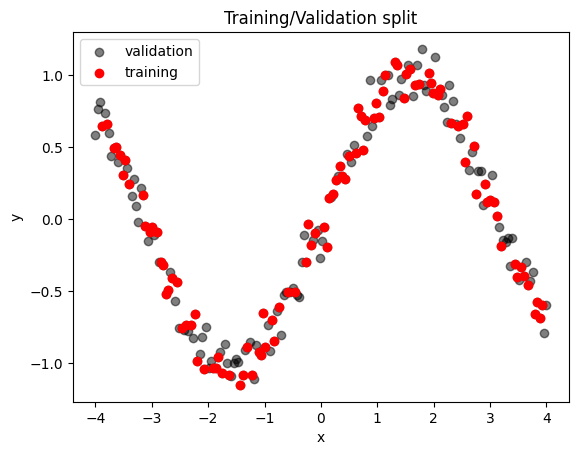

In [2]:
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = 0.1)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 10, 1]
num_epochs = 100
lli_net = LLI(model_dims)
sigma_0 = 0.1

100%|██████████| 100/100 [00:00<00:00, 176.13it/s]


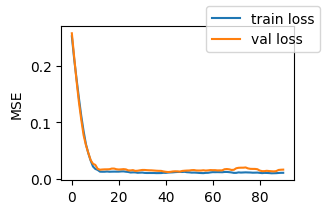

In [4]:
# train deep feature projector psi
lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

lli_net.eval()

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [5]:
with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

for param in lli_net.parameters():
    param.requires_grad = False

In [18]:
sigma_eps_sq = torch.tensor(0.1, dtype=torch.float32)   # fixed observational noise
sigma_0_sq   = torch.tensor(10.0, dtype=torch.float32)  # isotropic prior for w

post_lambdas, elbos = fit_vi_post_hoc(ys = ys_train.detach(), 
                               Psi = Psi.detach(), lr = 1e-2, 
                               num_iter = 10000, sigma_eps_sq = sigma_eps_sq, 
                               sigma_0_sq = torch.tensor(.1), 
                               mu_0 = lli_net.last_layer.weight.detach().squeeze(),
                               method = 'closed_form')

100%|██████████| 10000/10000 [00:02<00:00, 3617.16it/s]


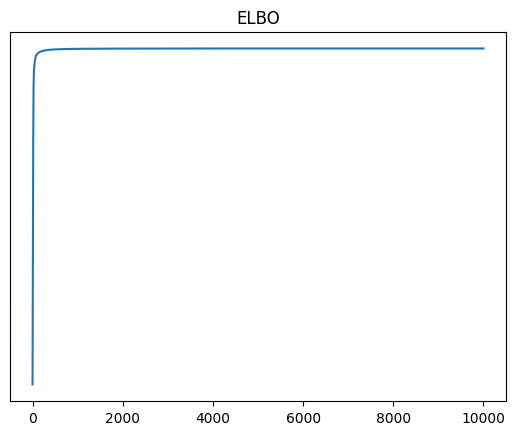

In [19]:
fig, axs = plt.subplots(1,1)
axs.plot(elbos)
axs.set_title('ELBO')
plt.yscale('symlog')

In [20]:
post_lambdas['mu']

tensor([ 0.0008,  0.0002,  0.0000, -0.0004, -0.0005, -0.0006, -0.0001, -0.0024,
        -0.0006,  0.0014])

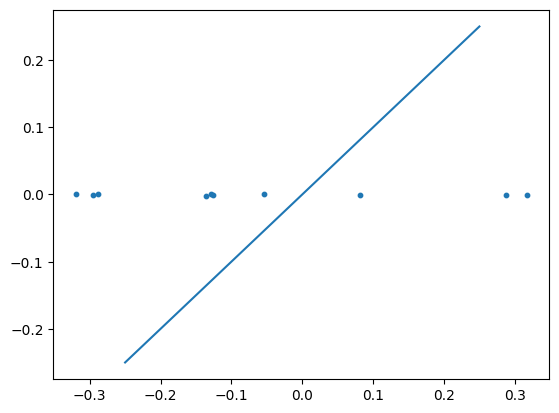

In [21]:
plt.scatter(lli_net.last_layer.weight.detach().numpy(), post_lambdas['mu'], s = 10)
plt.plot([-.25,.25], [-.25,.25])

In [10]:
def predictive_posterior(psi, mu_w, sigma_eps_sq, Sigma_w, ys_grid):
    p_hats = []
    for y in ys_grid:
        log_prob = get_log_likelihood_closed_form(ys = y, 
                                    Psi = psi,
                                    mu_w = mu_w,  
                                    sigma_eps_sq = sigma_eps_sq,
                                    Sigma_w = Sigma_w,
                                    N = 1
                                    )
        p_hats.append(torch.exp(log_prob))
    
    p_hats = torch.stack(p_hats) 
    y_mean = torch.trapz(p_hats*ys_grid,ys_grid)
    mean_sq_i = torch.trapz(p_hats * ys_grid**2, ys_grid)
    y_var = mean_sq_i - y_mean**2
    
    return {'p_hats': p_hats, 
            'y_mean': y_mean, 
            'y_var': y_var}

In [11]:
ys_grid = np.arange(-5,5, 0.01)
pred_post = [predictive_posterior(psi = Psi[i], mu_w = post_lambdas['mu'].detach(), 
                      sigma_eps_sq = sigma_eps_sq, 
                      Sigma_w = torch.eye(Psi.shape[1]), ys_grid = torch.tensor(ys_grid)) for i in tqdm(range(len(ys_train)))]


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/clarahoffmann/Documents/code/last_layer_inference/last-layer-inf/src/models/vi.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  var_component = 0.5 * (1.0 / sigma_eps_sq) * (Psi @ Sigma_w @ Psi.T)
100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


In [12]:
ys_grid = np.arange(-5,5, 0.01)
pred_post = [predictive_posterior(psi = Psi[i], mu_w = lli_net.last_layer.weight.detach().numpy().squeeze(), 
                      sigma_eps_sq = sigma_eps_sq, 
                      Sigma_w = torch.eye(Psi.shape[1]), ys_grid = torch.tensor(ys_grid)) for i in tqdm(range(len(ys_train)))]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 22.80it/s]


In [13]:
p_hats = torch.stack([d['p_hats'] for d in pred_post])
y_means = torch.stack([d['y_mean'] for d in pred_post])
y_vars = torch.stack([d['y_var'] for d in pred_post])

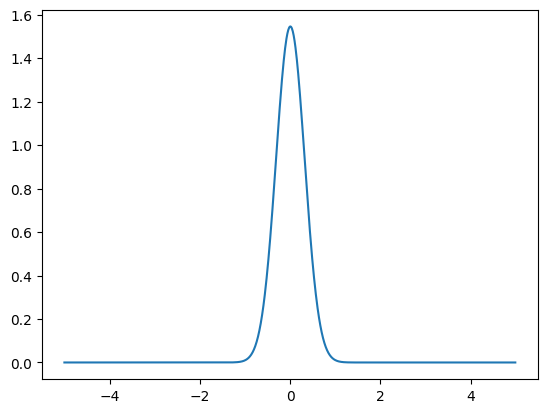

In [14]:
plt.plot(ys_grid, p_hats[0,:])

In [15]:
#lli_vi_pred_mu, lli_vi_pred_var = predictive_posterior(Psi =Psi, 
#                                                       mu = post_lambdas['mu'], 
#                                                       sigma = post_lambdas['sigma'], 
#                                                       sigma_eps_sq = sigma_eps_sq)
#lli_vi_pred_std = np.sqrt(lli_vi_pred_var)

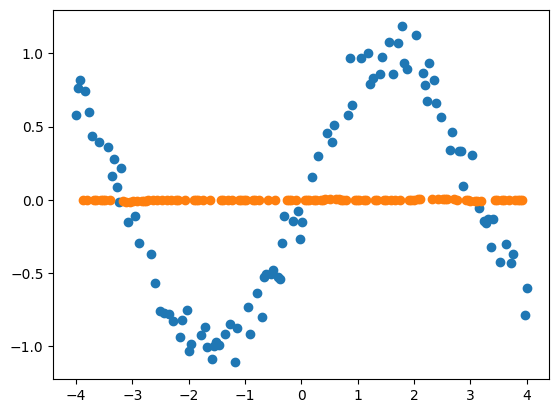

In [16]:
plt.scatter(xs_val, ys_val)
plt.scatter(xs_train, y_means)

# New try

In [2]:
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = 0.3)
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 10, 1]
num_epochs = 100

In [3]:
from torch import nn
from torch.optim import Adam

lli_net = LLI(model_dims)
    
params = list(lli_net.parameters())

model, losses_train, losses_val = train_last_layer_det(model = lli_net, dataloader_train = dataloader_train,
                     dataloader_val= dataloader_train, weight_decay = 0, num_epochs = 100)


for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

    
"""
# pretraining
optimizer = Adam(params, lr=1e-2)
loss_fn = nn.MSELoss()
losses_train = []
losses_val = []


# start training
for _ in tqdm(range(num_epochs)):
    # training step
    loss_train = 0
    for x, y in dataloader_train:
        optimizer.zero_grad()
        y_pred = lli_net.forward(x)
        loss = loss_fn(y, y_pred)  
        loss.backward()
        optimizer.step()
        loss_train += loss.item() * x.size(0)
    losses_train.append(loss_train/ len(dataloader_train.dataset))
    # val step
    val_loss = 0
    for x_val, y_val in dataloader_val:
        with torch.no_grad():
            y_pred_val = lli_net.forward(x_val)
            loss = loss_fn(y_val, y_pred_val)  
            val_loss += loss.item() * x_val.size(0)
    losses_val.append(val_loss / len(dataloader_val.dataset))"""



100%|██████████| 100/100 [00:00<00:00, 148.42it/s]


'\n# pretraining\noptimizer = Adam(params, lr=1e-2)\nloss_fn = nn.MSELoss()\nlosses_train = []\nlosses_val = []\n\n\n# start training\nfor _ in tqdm(range(num_epochs)):\n    # training step\n    loss_train = 0\n    for x, y in dataloader_train:\n        optimizer.zero_grad()\n        y_pred = lli_net.forward(x)\n        loss = loss_fn(y, y_pred)  \n        loss.backward()\n        optimizer.step()\n        loss_train += loss.item() * x.size(0)\n    losses_train.append(loss_train/ len(dataloader_train.dataset))\n    # val step\n    val_loss = 0\n    for x_val, y_val in dataloader_val:\n        with torch.no_grad():\n            y_pred_val = lli_net.forward(x_val)\n            loss = loss_fn(y_val, y_pred_val)  \n            val_loss += loss.item() * x_val.size(0)\n    losses_val.append(val_loss / len(dataloader_val.dataset))'

In [4]:
last_layer_vi = LastLayerVIClosedForm(dim_last_layer=Psi.shape[1], dim_output=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-2)
num_epochs = 10000
sigma_eps_sq = 0.1**2

elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    pred_y_mu= last_layer_vi.forward_det(Psi)
    
    L = last_layer_vi.get_L().squeeze()
    Sigma_w = L @ L.T

    kl = last_layer_vi.kl_divergence()

    log_likelihood = (-0.5 * Psi.shape[0] * torch.log(2 * torch.pi * torch.tensor(sigma_eps_sq)) \
        - 0.5  * torch.sum((ys_train - pred_y_mu) ** 2 / sigma_eps_sq) \
            - 0.5 *( torch.diagonal(Psi @ Sigma_w @ Psi.T).sum())/ sigma_eps_sq)
    
    elbo = (
        log_likelihood
        - kl
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 100 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f} \n 'log likelihood: {log_likelihood.item():.3f}")

    elbos.append(elbo.item())


VI epoch 0 ELBO: -28550.857 
 'log likelihood: -28550.188
VI epoch 100 ELBO: -2799.657 
 'log likelihood: -2799.070
VI epoch 200 ELBO: -1306.409 
 'log likelihood: -1305.265
VI epoch 300 ELBO: -868.463 
 'log likelihood: -866.844
VI epoch 400 ELBO: -689.146 
 'log likelihood: -687.112
VI epoch 500 ELBO: -589.233 
 'log likelihood: -586.821
VI epoch 600 ELBO: -520.771 
 'log likelihood: -518.002
VI epoch 700 ELBO: -469.530 
 'log likelihood: -466.414
VI epoch 800 ELBO: -429.960 
 'log likelihood: -426.501
VI epoch 900 ELBO: -398.937 
 'log likelihood: -395.139
VI epoch 1000 ELBO: -374.318 
 'log likelihood: -370.182
VI epoch 1100 ELBO: -354.551 
 'log likelihood: -350.080
VI epoch 1200 ELBO: -338.498 
 'log likelihood: -333.697
VI epoch 1300 ELBO: -325.324 
 'log likelihood: -320.197
VI epoch 1400 ELBO: -314.396 
 'log likelihood: -308.950
VI epoch 1500 ELBO: -305.484 
 'log likelihood: -299.724
VI epoch 1600 ELBO: -297.521 
 'log likelihood: -291.455
VI epoch 1700 ELBO: -290.938 
 'log

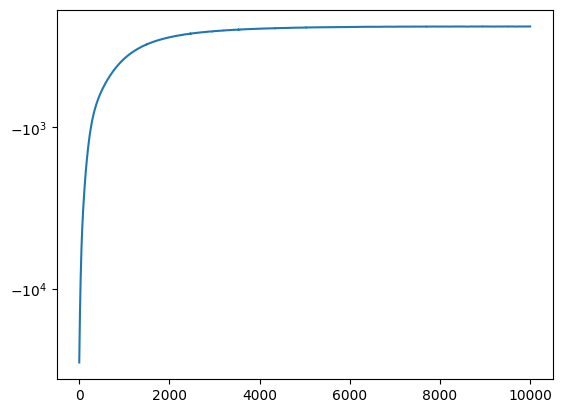

In [5]:
plt.plot(elbos)
plt.yscale('symlog')

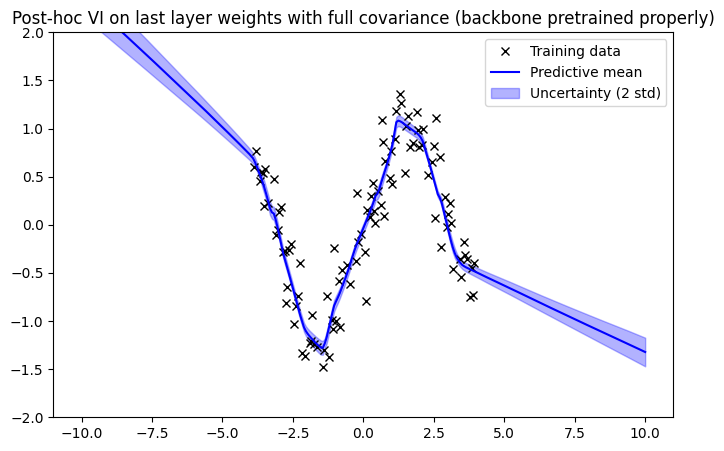

In [6]:

# Plot
last_layer_vi.eval()
with torch.no_grad():
    X_test = torch.linspace(-10,10, 300).unsqueeze(1)
    features_test = lli_net.get_ll_embedd(X_test)
    preds_samples = []
    for _ in range(100):
        preds, _ = last_layer_vi.forward_sample(features_test)
        preds_samples.append(preds.squeeze())
    preds_samples = torch.stack(preds_samples)
    mean_pred = preds_samples.mean(dim=0)
    std_pred = preds_samples.std(dim=0)

plt.figure(figsize=(8,5))
plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), mean_pred.numpy(), 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 mean_pred.numpy() - 2 * std_pred.numpy(),
                mean_pred.numpy() + 2 * std_pred.numpy(),
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()


# Ridge

In [ ]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVI(nn.Module):
    def __init__(self, in_features, out_features, prior_var=.3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.prior_var = prior_var
        self.prior_cov = torch.eye(in_features) * prior_var
        self.prior_cov_inv = torch.inverse(self.prior_cov)
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.L_unconstrained = nn.Parameter(torch.randn(out_features, in_features, in_features) * 0.01)
    
    def get_L(self):
        L = torch.tril(self.L_unconstrained)
        diag_idx = torch.arange(self.in_features)
        L[:, diag_idx, diag_idx] = torch.nn.functional.softplus(L[:, diag_idx, diag_idx]) + 1e-5
        return L
    
    def forward_det(self, X):
        w_samples = self.mu #+ torch.einsum('oij,oj->oi', L, eps)
        return X @ w_samples.t(), w_samples
    
    def forward_sample(self, X):
        L = self.get_L()
        eps = torch.randn_like(self.mu)
        w_samples = self.mu + torch.einsum('oij,oj->oi', L, eps)
        return X @ w_samples.t(), w_samples
    
    def kl_divergence(self):
        L = self.get_L()
        Sigma_q = torch.einsum('oik,okj->oij', L, L)
        
        log_det_prior = self.in_features * torch.log(torch.tensor(self.prior_var))
        log_det_q = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)), dim=1)
        
        mu = self.mu
        
        trace_term = torch.einsum('oi,ij,oj->o', mu, self.prior_cov_inv, mu) + \
                     torch.einsum('oij,ji->o', Sigma_q, self.prior_cov_inv)
        
        kl = 0.5 * (log_det_prior - log_det_q - self.in_features + trace_term)
        return kl.sum()

### chatgpt

Pretraining epoch 0 loss: 0.6245
Pretraining epoch 200 loss: 0.0482
Pretraining epoch 400 loss: 0.0324
Pretraining epoch 600 loss: 0.0305
Pretraining epoch 800 loss: 0.0317
VI epoch 0 ELBO: -23868.154
VI epoch 100 ELBO: -8530.015
VI epoch 200 ELBO: -19784.266
VI epoch 300 ELBO: -6721.115
VI epoch 400 ELBO: -1804.560
VI epoch 500 ELBO: -52417.609
VI epoch 600 ELBO: -7466.313
VI epoch 700 ELBO: -10982.781
VI epoch 800 ELBO: -3022.638
VI epoch 900 ELBO: -5537.105


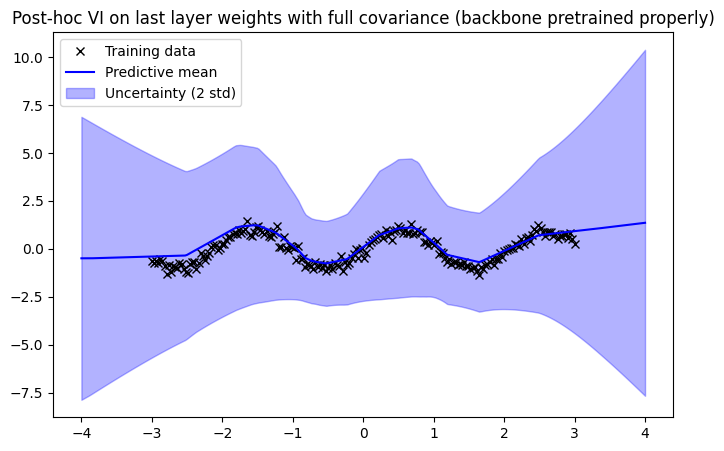

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Generate data
N = 200
X_data = torch.linspace(-3, 3, N).unsqueeze(1)
y_true = torch.sin(3 * X_data).squeeze()
noise_std = 0.2
y_data = y_true + noise_std * torch.randn_like(y_true)
y_data = y_data.unsqueeze(1)

# Backbone + output head for pretraining
class Backbone(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class Head(nn.Module):
    def __init__(self, in_features, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        return self.linear(x)

backbone = Backbone()
head = Head(in_features=50)

# Pretrain backbone + head end-to-end
params = list(backbone.parameters()) + list(head.parameters())
optimizer = optim.Adam(params, lr=1e-2)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    optimizer.zero_grad()
    features = backbone(X_data)
    preds = head(features)
    loss = loss_fn(preds, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Pretraining epoch {epoch} loss: {loss.item():.4f}")

# Freeze backbone (keep head for last layer VI)
for param in backbone.parameters():
    param.requires_grad = False

# Extract features (frozen)
with torch.no_grad():
    features = backbone(X_data)

# Variational last layer on top of frozen features
class LastLayerVI(nn.Module):
    def __init__(self, in_features, out_features, prior_var=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.prior_var = prior_var
        self.prior_cov = torch.eye(in_features) * prior_var
        self.prior_cov_inv = torch.inverse(self.prior_cov)
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.L_unconstrained = nn.Parameter(torch.randn(out_features, in_features, in_features) * 0.01)
    
    def get_L(self):
        L = torch.tril(self.L_unconstrained)
        diag_idx = torch.arange(self.in_features)
        L[:, diag_idx, diag_idx] = torch.nn.functional.softplus(L[:, diag_idx, diag_idx]) + 1e-5
        return L
    
    def forward(self, X):
        L = self.get_L()
        eps = torch.randn_like(self.mu)
        w_samples = self.mu + torch.einsum('oij,oj->oi', L, eps)
        return X @ w_samples.t(), w_samples
    
    def kl_divergence(self):
        L = self.get_L()
        Sigma_q = torch.einsum('oik,okj->oij', L, L)
        
        log_det_prior = self.in_features * torch.log(torch.tensor(self.prior_var))
        log_det_q = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)), dim=1)
        
        mu = self.mu
        
        trace_term = torch.einsum('oi,ij,oj->o', mu, self.prior_cov_inv, mu) + \
                     torch.einsum('oij,ji->o', Sigma_q, self.prior_cov_inv)
        
        kl = 0.5 * (log_det_prior - log_det_q - self.in_features + trace_term)
        return kl.sum()

last_layer_vi = LastLayerVI(in_features=features.shape[1], out_features=1)
optimizer_vi = optim.Adam(last_layer_vi.parameters(), lr=1e-2)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    outputs, _ = last_layer_vi(features)
    likelihood = torch.distributions.Normal(outputs, noise_std)
    log_lik = likelihood.log_prob(y_data).sum()
    kl = last_layer_vi.kl_divergence()
    elbo = log_lik - kl
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 100 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

# Plot
last_layer_vi.eval()
with torch.no_grad():
    X_test = torch.linspace(-4, 4, 300).unsqueeze(1)
    features_test = backbone(X_test)
    preds_samples = []
    for _ in range(100):
        preds, _ = last_layer_vi(features_test)
        preds_samples.append(preds.squeeze())
    preds_samples = torch.stack(preds_samples)
    mean_pred = preds_samples.mean(dim=0)
    std_pred = preds_samples.std(dim=0)

plt.figure(figsize=(8,5))
plt.plot(X_data.numpy(), y_data.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), mean_pred.numpy(), 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 mean_pred.numpy() - 2 * std_pred.numpy(),
                 mean_pred.numpy() + 2 * std_pred.numpy(),
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()
